In [14]:
library(tidyverse)
library(tidymodels)

## **Group 2 Project report:**
Pushya Jain, Kelly Tang, Mayank Verma
Intro question: **Can the various chemical attributes determine the quality score of the wine pre-emptively?** Applicable for businesses such as wineries and other industry partners who can use this data analysis to see which wines are the best quality depending on the included attributes and then use it for further research into what wines should be on their shelves etc

## **Expected outcomes and significance:**
What do you expect to find? Relationships between certain chemical attributes of the wine affecting the wine quality score
Impact: Using the classification to immediately assign a quality score to wines based on known attributes, narrowing down the searches, acting as a quick way to predict the quality score without having to manually evaluate the data.
The chemical conditions to create a wine with the best quality score can be calculated quickly beforehand instead of trial and error to figure it out which can help several wineries out.
Future questions include what further research can be done to apply this data analysis to compare the popularity of certain wines and how can wineries adjust their business model and inventory to account for the classification of better quality wines?
The classifier could be adapted further (if more data and attributes is provided) to classify the type of wine too. 

## **Reading and Mutating the Data**
We removed ID and quality variables because it is not useful to our analysis.
We will do forward selection to further improve accuracy later. We will turn our target variable (wine quality score) into factor after the data visualisation


In [15]:
set.seed(5)

wine <- read_csv("WineQT.csv") %>% select(-Id)
colnames(wine) <- colnames(wine) %>% make.names()

Parsed with column specification:
cols(
  `fixed acidity` = col_double(),
  `volatile acidity` = col_double(),
  `citric acid` = col_double(),
  `residual sugar` = col_double(),
  chlorides = col_double(),
  `free sulfur dioxide` = col_double(),
  `total sulfur dioxide` = col_double(),
  density = col_double(),
  pH = col_double(),
  sulphates = col_double(),
  alcohol = col_double(),
  quality = col_double(),
  Id = col_double()
)



## **Creating Data Visualisation** 
Line graphs are made with wine score on the x-xais and the values of attributes on the y-axis.
This is to notice whether the values of the attributes are different for each wine score or not as the those attributes that vary with wine score will be more helpful to classify the wine score itself. 
## Sample Visualization for different predictors present

`summarise()` regrouping output by 'attributes' (override with `.groups` argument)



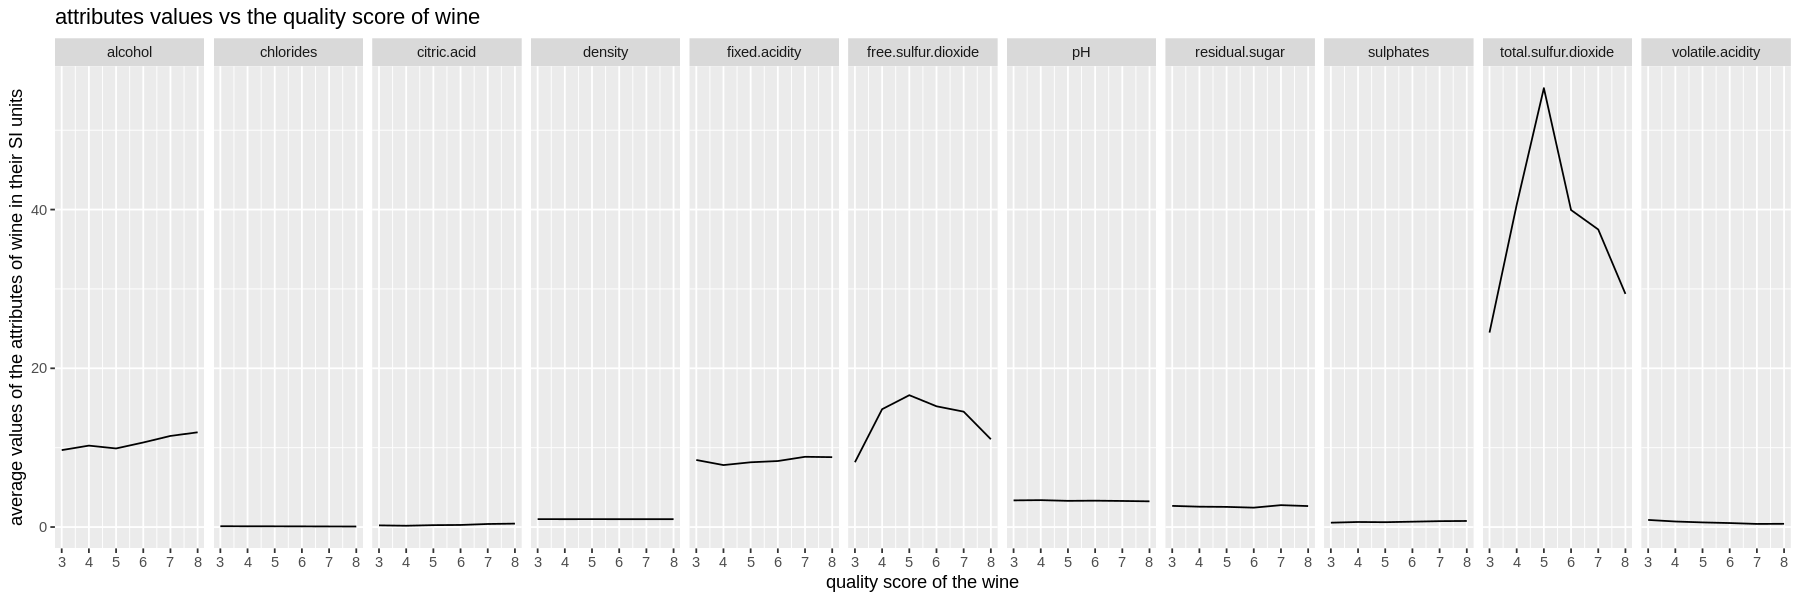

In [18]:
set.seed(5)
wine_longer <- pivot_longer(wine,
                           cols= fixed.acidity:alcohol,
                           names_to = "attributes",
                           values_to = "values") %>%
                            group_by(attributes, quality) %>%
                            summarise(values = mean(values))

options(repr.plot.height = 5, repr.plot.width = 15)

wine_plot <- wine_longer %>% 
            ggplot(aes(x  = quality, y = values)) + geom_line() + 
            facet_grid(. ~ attributes) + 
            labs (x = "quality score of the wine",
                 y = "average values of the attributes of wine in their SI units") +
            ggtitle("attributes values vs the quality score of wine")

wine_plot 


## **Preliminary Exploratory Data Analysis**
The graph was converted into a pivot_longer graph and then using the facet_grid function multiple line graphs were generated for different attributes. The quality of wine is on the x-axis and the average value of the attributes is the y-axis. Those attributes that have a change in the average attribute values (graphs that have don’t have a gradient of 0 by eye) will be chosen because that means the attributes have a correlation with the quality of the wine.
Predictors will be used to classify the wine score and those variables that are the same for all the wine scores will most likely not help the model.
Based on this, the predictors chosen are:
alcohol,
fixed acidity,
free sulfur dioxide,
and total sulfur dioxide.
The predictors may be rechosen based on the forward selection method later on for improving the accuracy of the model. 

## **Cross validation plot to find the k neighbour**

In [1]:
set.seed(5)

## selected predictors
wine <- wine %>% mutate(qual = as_factor(quality)) %>% select(fixed.acidity,alcohol,free.sulfur.dioxide, total.sulfur.dioxide,qual)

## Training the Data

wine_split <- initial_split(wine, prop = 0.75, strata = qual)
wine_train <- training(wine_split)
wine_test <- testing(wine_split)

## recipe
wine_recipe <- recipe(qual ~ ., data = wine_train) %>%
  step_scale(all_predictors()) %>%
  step_center(all_predictors()) 

## cross validation plot to find the k-neighbours with the highest accuracy

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine("kknn")%>%
    set_mode("classification")

wine_vfold <- vfold_cv(wine_train, v = 5, strata = qual)


wine_resample_fit <- workflow() %>%
                add_recipe(wine_recipe) %>%
                add_model(knn_spec) %>%
                tune_grid(resamples = wine_vfold, grid = 10) %>%
                collect_metrics() %>%
                filter(.metric == "accuracy")

wine_crossval_plot <- cross_val_plot <-  ggplot(wine_resample_fit, aes(x = neighbors, y = mean))+
               geom_point() +
               geom_line() +
               labs(x = "Neighbors", y = "Accuracy Estimate") +
               scale_x_continuous(breaks = seq(0, 14, by = 1)) +  # adjusting the x-axis
                scale_y_continuous(limits = c(0.4, 1.0)) # adjusting the y-axis
                
wine_crossval_plot

k_max <- wine_resample_fit %>% arrange(desc(mean)) %>% slice(1) #%>% pull(neighbors) #neighbour with highest accuracy


ERROR: Error in wine %>% mutate(qual = as_factor(quality)) %>% select(fixed.acidity, : could not find function "%>%"


exlpaination of what we did

## **Training the model with k_max neighbour and finding the accuracy**

In [ ]:
set.seed(5)

## training the model with k_min
    
wine_spec_1 <- nearest_neighbor(weight_func = "rectangular", neighbors = 14) %>%
                set_engine("kknn")%>%
                set_mode("classification")

wine_model_1 <- workflow() %>%
                add_recipe(wine_recipe) %>%
                add_model(wine_spec_1) %>%
                fit(data = wine_train)

## testing the accuracy

wine_predict_1 <- predict(wine_model_1, wine_test) %>%
                    bind_cols(wine_test) %>%
                    metrics(truth = qual, estimate = .pred_class) %>%
                    filter(.metric == "accuracy")

wine_confmat_1 <- predict(wine_model_1, wine_test) %>%
                    bind_cols(wine_test) %>%
                    conf_mat(truth = qual, estimate = .pred_class)

wine_predict_1
wine_confmat_1

what we did
analysis
what does it mean

## **Forward selection**

what went wrong

the predictors were not selected in a more mathematical way

what we did

## Future Questions:
- What further research can be done to apply this data analysis to compare the popularity of certain wines?
- How can wineries adjust their business model and inventory to account for the classification of better quality wines?
- The classifier could be adapted further (if more data and attributes is provided) to classify the type of wine too. 

